In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
from copy import deepcopy
import pathlib

data_social = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/social'
_incomes = ['household', 'family', 'married', 'nonfamily']
data_bikes = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/bikes'

categorical = True

zipcode_file = pathlib.Path("/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/tl_2017_us_zcta510.zip")
# Check existence
if zipcode_file.exists():
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
else:
    print("File not found! Make sure it's in the current directory.")

In [13]:
def get_number_trips(path):
    '''
    function to get the number of trips for each station
    
    Inputs:
        - path: str, the path of the file
    
    Outputs:
        - stations: dict, the stations with the number of trips starting and ending at each station
    '''
    stations = dict()
    
    for file in os.listdir(path):
        full_path = os.path.join(path, file)
        df = pd.read_csv(full_path, dtype=object)
        
        for index in range(len(df.index)):
            
            if 'latitude_start' in df.columns:
                start_station = df['station_start'][index]
                end_station = df['station_end'][index]
                start_lat = df['latitude_start'][index]
                start_lon = df['longitude_start'][index]
                end_lat = df['latitude_end'][index]
                end_lon = df['longitude_end'][index]
                
                if start_station not in stations:
                    
                    stations[start_station] = {
                        'lat': start_lat,
                        'lon': start_lon,
                        'start' : 1,
                        'end' : 0
                    }
                else:
                    stations[start_station]['start'] += 1
                if end_station not in stations:
                    
                    stations[end_station] = {
                        'lat': end_lat,
                        'lon': end_lon,
                        'start' : 0,
                        'end' : 1
                    }
                else:
                    stations[end_station]['end'] += 1
    
    return stations

In [14]:
def get_gender(df):
    '''
    function to get the gender from the social data and plot it
    
    Inputs:
        - df: pandas dataframe
    
    Outputs:
        - the most common age or the mean age
    '''
    
    if categorical:
        estimates = list()
        margins = list()
        is_age = False
        for i in range(30):
            if df['label'][i].endswith('Under 5 years'):
                is_age = True
            if is_age:
                estimate = df['total_estimates'][i]
                if type(estimate) == float:
                    estimate = str(estimate)
                estimate = int(estimate.replace(',', ''))
                estimates.append(estimate)
            if df['label'][i].endswith('85 years and over'):
                break
        # return the maximum value
        ages = ['<5', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44',
                '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']
        max_total = estimates.index(max(estimates))
        return ages[max_total]
    else:
        for i in range(40):
            if df['label'][i].endswith('Median age (years)'):
                estimate = df['total_estimates'][i]
                if estimate != '-':
                    return float(df['total_estimates'][i])
        return None

def get_income(df):
    '''
    function to get the income from the social data and plot it
    
    Inputs:
        - df: pandas dataframe
    
    Outputs:
        - the most common income or the median income
    '''
    estimates = {
        'household': list(),
        'family': list(),
        'married': list(),
        'nonfamily': list()
    }
    if categorical:
        is_income = False
        for i in range(16):
            if df['label'][i].endswith('Less than $10,000'):
                is_income = True
            if is_income:
                for type in ['household', 'married', 'nonfamily', 'family']:
                    if df[type + '_estimates'][i] == '-':
                        return None, None, None, None
                    estimate = float(df[type + '_estimates'][i][:-1])
                    estimates[type].append(estimate)
            if df['label'][i].endswith('$200,000 or more'):
                is_income = False
        
        # return the maximum value
        incomes = ['<10,000', '10,000-14,999', '15,000-24,999', '25,000-34,999', '35,000-49,999',
                '50,000-74,999', '75,000-99,999', '100,000-149,999', '150,000-199,999', '200,000+']
        return incomes[estimates['household'].index(max(estimates['household']))], incomes[estimates['married'].index(max(estimates['married']))], incomes[estimates['nonfamily'].index(max(estimates['nonfamily']))], incomes[estimates['family'].index(max(estimates['family']))]
    else:
        for i in range(16):
            if df['label'][i].endswith('Median income (dollars)'):
                for type in ['household', 'married', 'nonfamily', 'family']:
                    estimate = df[type + '_estimates'][i]
                    if estimate == '-':
                        return None, None, None, None
                    else:
                        if estimate.endswith('+'):
                            estimate = estimate[:-1]
                        estimate = int(estimate.replace(',', ''))
                        estimates[type].append(estimate)
        return estimates['household'][0], estimates['married'][0], estimates['nonfamily'][0], estimates['family'][0]
    
def get_race(df):
    '''
    the function to get the race from the social data and plot it
    
    Input:
        - df: pandas dataframe
    
    Output:
        - the most common race
    '''
    
    estimates = list()
    
    is_race = False
    for i in range(10):
        if df['label'][i].endswith('White alone'):
            is_race = True
        if is_race:
            estimate = df['total_estimates'][i]
            if type(estimate) != str:
                estimate = str(estimate)
            estimate = int(estimate.replace(',', ''))
            estimates.append(estimate)
        if df['label'][i].endswith('Two or More Races'):
            is_race = False
    
    # return the maximum value
    races = ['White', 'Black or \n African American', 'Indian and \n Alaska Native',
        'Asian', 'Native Hawaiian', 'Some Other Race', 'Two or More Races']
    return races[estimates.index(max(estimates))]

In [15]:
def plot_bikes(city, year):
    
    path = os.path.join(data_bikes, city, year)
    stations = get_number_trips(path)
    
    latitudes = list()
    longitudes = list()
    sizes = list()
    colors = list()
    names = list()
    
    for name, station in stations.items():
        start = station['start']
        end = station['end']
        
        size = max(start, end)
        sizes.append(size / 1000)
        if size == start:
            colors.append('red')
        else:
            colors.append('blue')

        latitudes.append(station['lat'])
        longitudes.append(station['lon'])
        names.append(name)
    
    bikes = pd.DataFrame({
        'name': names,
        'lat': latitudes,
        'lon': longitudes,
        'size': sizes,
        'color': colors
    })
    
    return bikes

def plot_map(city_name, function, path, year):
    
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
    city = deepcopy(zipcode_gdf)
    
    results = list()
    
    for zip in os.listdir(path):
        
        if not zip.endswith('.csv'):
        
            zip_path = os.path.join(path, zip)
            
            for file in os.listdir(zip_path):
                
                file_path = os.path.join(zip_path, file)
                df = pd.read_csv(file_path)
            
                if function == 'income' and file == 'income.csv':
                    household, married, nonfamily, family = get_income(df)
                    if household is not None:
                        city.loc[city.ZCTA5CE10.str.startswith(zip), 'household'] = household
                        city.loc[city.ZCTA5CE10.str.startswith(zip), 'married'] = married
                        city.loc[city.ZCTA5CE10.str.startswith(zip), 'nonfamily'] = nonfamily
                        city.loc[city.ZCTA5CE10.str.startswith(zip), 'family'] = family
                elif function == 'gender' and file == 'gender.csv':
                    maximum = get_gender(df)
                    if maximum is not None:
                        city.loc[city.ZCTA5CE10.str.startswith(zip), 'result'] = maximum
                elif function == 'race' and file == 'race.csv':
                    maximum = get_race(df)
                    if maximum is not None:
                        city.loc[city.ZCTA5CE10.str.startswith(zip), 'result'] = maximum

    bikes = plot_bikes(city_name)
    
    if function == 'gender':
        
        city = city[city['result'].notna()]
            
        if categorical:
            order = ['<5', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44',
                    '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']
            
            base = city.plot(column='result', cmap='viridis', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}, categories = order)
                
        else:
            base = city.plot(column='result', cmap='viridis', legend = True)
        
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(f'Gender in {city_name} in 2022')
        
        # insert the points on the map
        geopuffer = gpd.GeoDataFrame(bikes, geometry = gpd.points_from_xy(bikes.lon, bikes.lat))
        geopuffer.plot(ax=base, color=geopuffer['color'], markersize=geopuffer['size'], legend=True)
        
    elif function == 'income':
        
        city = city[city['household'].notna()]
        
        if categorical:
            
            order = ['<10,000', '10,000-14,999', '15,000-24,999', '25,000-34,999', '35,000-49,999',
                    '50,000-74,999', '75,000-99,999', '100,000-149,999', '150,000-199,999', '200,000+']
            
            for type in _incomes:
                base = city.plot(column=type, cmap='viridis', categorical = True, categories = order, legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}, edgecolor='black')
                plt.xticks([], [])
                plt.yticks([], [])
                plt.title(type + ' income in ' + city_name + ' in 2022')
                if results:
                    for type in _incomes:
                        counters = {income: 0 for income in order}
                        for income in city[type]:
                            counters[income] += 1
                        print(counters)
                
                geopuffer = gpd.GeoDataFrame(bikes, geometry = gpd.points_from_xy(bikes.lon, bikes.lat))
                _ = geopuffer.plot(ax=base, color=geopuffer['color'], markersize=geopuffer['size'], legend=True)
                
        else:
                
            fig, ax = plt.subplots(2, 2, figsize=(7, 7))
            
            for x in [0, 1]:
                for y in [0, 1]:
                    type = _incomes[x + y * 2]
                    base = city.plot(column=type, cmap='viridis', ax=ax[x, y])
                    ax[x, y].set_xticks([], [])
                    ax[x, y].set_yticks([], [])
                    plt.suptitle('Income in ' + city_name + ' in 2022')
                    ax[x, y].set_title(type)      
                
                    geopuffer = gpd.GeoDataFrame(bikes, geometry = gpd.points_from_xy(bikes.lon, bikes.lat))
                    geopuffer.plot(ax=base, color=geopuffer['color'], markersize=geopuffer['size'], legend=True)
                    
            axs = ax.ravel()
            fig.colorbar(ax[0, 0].collections[0], ax=axs, shrink= 0.5)
            
    
    elif function == 'race':
        
        city = city[city['result'].notna()]
        
        order = ['White', 'Black or \n African American', 'Indian and \n Alaska Native',
            'Asian', 'Native Hawaiian', 'Some Other Race', 'Two or More Races']
        
        base = city.plot(column='result', cmap='viridis', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}, categories = order)
        
        plt.title(f'Races in {city_name} in {year}')
        plt.xticks([], [])
        plt.yticks([], [])
        
        geopuffer = gpd.GeoDataFrame(bikes, geometry = gpd.points_from_xy(bikes.lon, bikes.lat))
        _ = geopuffer.plot(ax=base, color=geopuffer['color'], markersize=geopuffer['size'], legend=True)
    
    plt.show()

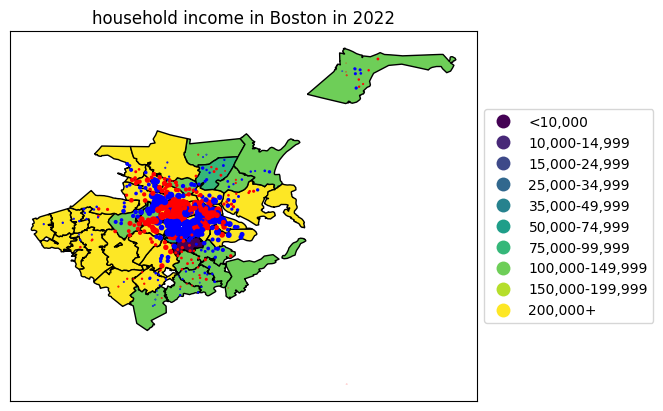

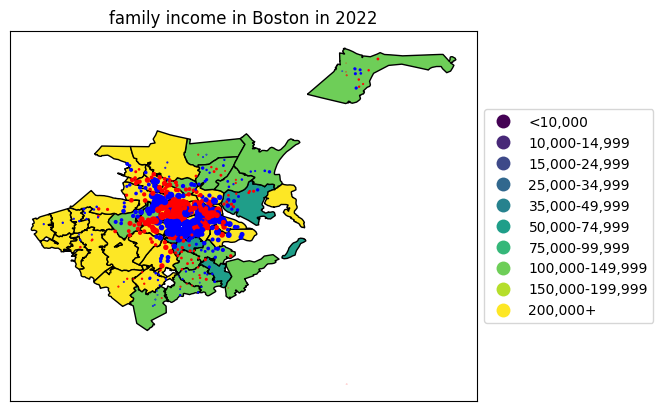

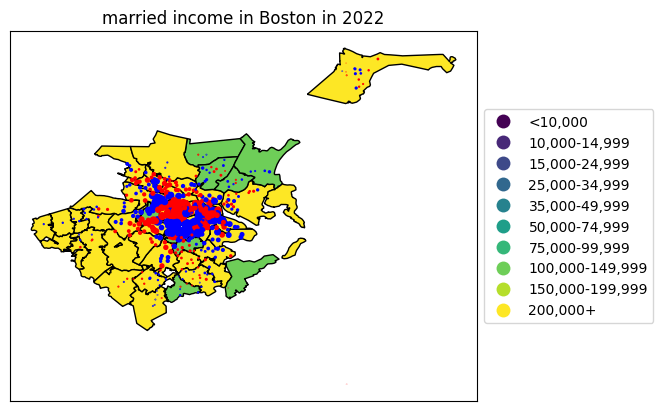

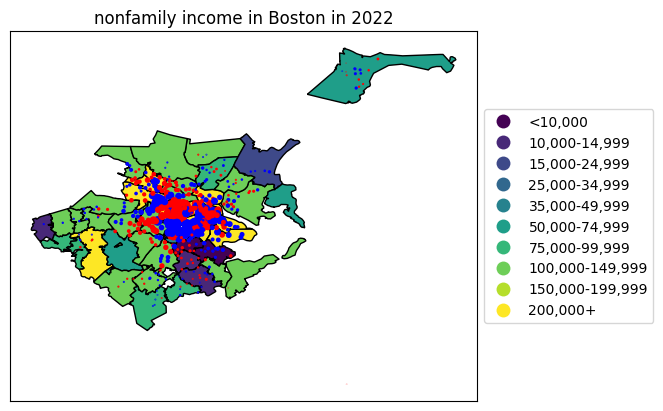

In [16]:
# function: income, race, gender
function = 'income'
city = 'Boston'
year = '2022'

city_path = os.path.join(data_social, city)    
year_path = os.path.join(city_path, year)

plot_map(city, function, year_path, year)